In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm

# Number of data points
NUM_SAMPLES = 1000

# Kinetic parameters
MU_MAX = 0.86980       # 1/h
K_S    = 0.000123762       # g/l
Y_XS   = 0.4357       # g/g
Y_PX   = 0.2         # g/g
S_F    = 1.43 * 200  # g/l
K_I    = 54

# Initial conditions
X_0 = 5
S_0 = 0.013
V_0 = 1.7

# ODE solver parameters
ODE_SOLVER = 'RK45'

# Time parameters
T_START = 0
T_END = 5
TIME_RANGE = int(T_END - T_START) # Absolute time 

# Actual system dynamics
def actual_system(t: float, y: float, F: float, k_d: float = 0.009):
    ''' Real system model with cell death and substrate inhibition '''
    X, S, V = y
    mu = MU_MAX * S / (K_S + S + S**2 / K_I)  # Monod equation
    dX_dt = mu * X - (F / V) * X - k_d * X
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S) 
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]
    
# System dynamics
def system_dynamics(t, y, F) -> np.array:
    X, S, V = y
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt, dV_dt])

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval, rtol=1e-6, atol=1e-12)
    # sol.y = np.maximum(sol.y, 0)
    return sol

def plot_solution(sol: solve_ivp) -> None:
    plt.figure(figsize=(12,4))
    plt.plot(sol.t, sol.y[0], label='Biomass')
    plt.plot(sol.t, sol.y[1], label='Substrate')
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/l)')
    plt.legend()
    plt.show()

In [12]:
# MPC parameters
dt = 0.1                         # Time step
L = int(TIME_RANGE / dt)       # Number of steps
N_p = 5                         # Prediction horizon
Q = 1.5                         # Weight for tracking
R = 0.5                            # Weight for control effort
Q_term = 0.0                     # Weight for terminal state
OPTIMIZATION_METHOD = 'SLSQP' # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

# Bounds for feeding rate
F_MIN = 0.0                  # l/h
F_MAX = 0.1                  # l/h
DELTA_F_MAX = 0.05           # Maximum change in feed rate
F_0 = (F_MAX - F_MIN) / 2    # Initial feed rate
BOUNDS = [(F_MIN, F_MAX) for _ in range(N_p)] 

# X_setpoint
X_sp = 25

print(f'Number of steps: {L} and dt: {dt}')

Number of steps: 50 and dt: 0.1


In [13]:
# ----- Cost function -----
def cost_function(F_opt: list, X: float, S: float, V: float) -> float:
    J = 0
    for k in range(N_p):
        sol = solve_ode(system_dynamics, t_span=[0, dt], y0=[X, S, V], method=ODE_SOLVER, t_eval=[dt], args=(F_opt[k],))      
        X_next = sol.y[0][-1]
        S_next = sol.y[1][-1]
        V_next = sol.y[2][-1]
        J += Q * (X_sp - X_next) ** 2
        if k > 0:
            J += R * (F_opt[k] - F_opt[k - 1]) ** 2
        X, S, V = X_next, S_next, V_next
    return J

In [14]:
X = np.zeros(L)
S = np.zeros(L)
V = np.zeros(L)
F = np.zeros(L)
X[0], S[0], V[0] = X_0, S_0, V_0

USE_ACTUAL_DYNAMICS = True
for i in tqdm(range(L-1)):
    res = minimize(cost_function, np.zeros(N_p), args=(X[i], S[i], V[i]), bounds=BOUNDS, method=OPTIMIZATION_METHOD)
    F_new = res.x[0]
    F[i+1] = F_new
    if USE_ACTUAL_DYNAMICS:
        # Use actual system dynamics
        sol = solve_ode(actual_system, t_span=[0, dt], y0=[X[i], S[i], V[i]], method=ODE_SOLVER, t_eval=[dt], args=(F_new,))
        # Add "measurement noise" to the solution
        sol.y[0][1:] += np.random.normal(0, sol.y[0].max() * 0.02, size=sol.y[0][1:].shape)
        sol.y[1][1:] += np.random.normal(0, sol.y[1].max() * 0.02, size=sol.y[1][1:].shape)
    else:
        # Use system dynamics
        sol = solve_ode(system_dynamics, t_span=[0, dt], y0=[X[i], S[i], V[i]], method=ODE_SOLVER, t_eval=[dt], args=(F_new,))
    X[i+1] = sol.y[0][-1]
    S[i+1] = sol.y[1][-1]
    V[i+1] = sol.y[2][-1]


100%|██████████| 49/49 [30:11<00:00, 36.96s/it]


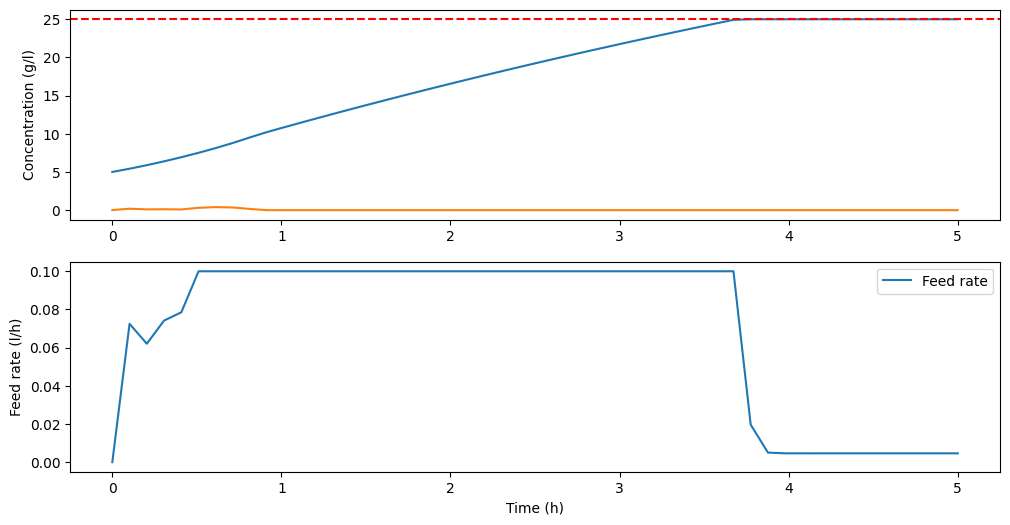

In [15]:
time= np.linspace(T_START, T_END, L)
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(time, X, label='Biomass')
plt.plot(time, S, label='Substrate')
plt.axhline(y=X_sp, color='r', linestyle='--', label='Setpoint')
plt.ylabel('Concentration (g/l)')

plt.subplot(2,1,2)
plt.plot(time, F, label='Feed rate')
plt.xlabel('Time (h)')
plt.ylabel('Feed rate (l/h)')
plt.legend()
plt.show()